In [1]:
import kagglehub
import pandas as pd 
import numpy as np
import random
import os
import shutil
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image
import tensorflow as tf
import sys 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.preprocessing import * 
from src.model import * 

/Users/muskaan2/ML_Dev/ml_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
#filepaths 
data_dir = "/Users/muskaan2/ML_Dev/data"
train_filepath = data_dir + '/processed_images/train/'
test_filepath = data_dir + '/processed_images/test/'

In [5]:
# Create data directory if it doesn't exist
path = kagglehub.dataset_download("nandanp6/cataract-image-dataset")
print("Path to dataset files:", path)

# Copy all files from kaggle download path to data folder
for file in os.listdir(path):
    src_path = os.path.join(path, file)
    dst_path = os.path.join(data_dir, file)
    if os.path.isfile(src_path):
        shutil.copy2(src_path, dst_path)
    elif os.path.isdir(src_path):
        if os.path.exists(dst_path):
            shutil.rmtree(dst_path)
        shutil.copytree(src_path, dst_path)

Path to dataset files: /Users/muskaan2/.cache/kagglehub/datasets/nandanp6/cataract-image-dataset/versions/3


Sample Normal Images:
/Users/muskaan2/ML_Dev/data/processed_images/train/normal


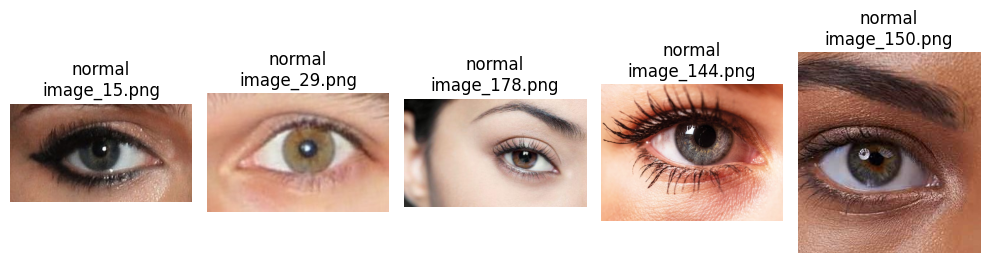


Sample Cataract Images:
/Users/muskaan2/ML_Dev/data/processed_images/train/cataract


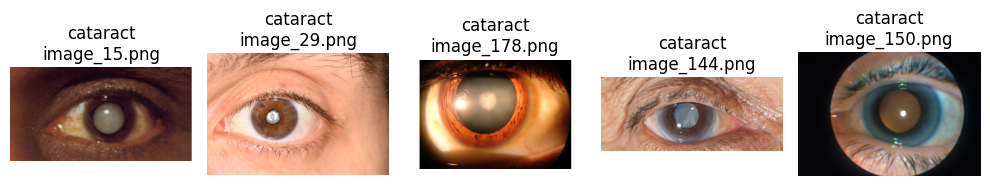

In [6]:
# Function to display sample images
def display_sample_images(category, num_samples=5):
    category_path = os.path.join(data_dir+'/processed_images', 'train', category)
    print(category_path)
    image_files = os.listdir(category_path)[:num_samples]
    
    plt.figure(figsize=(10, 3))
    for idx, image_file in enumerate(image_files):
        img_path = os.path.join(category_path, image_file)
        img = Image.open(img_path)
        
        plt.subplot(1, num_samples, idx + 1)
        plt.imshow(img)
        plt.title(f'{category}\n{image_file}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display sample images for both categories
print("Sample Normal Images:")
display_sample_images('normal')

print("\nSample Cataract Images:")
display_sample_images('cataract')

In [7]:
def plot_combined_distribution():
    # Get counts for training data
    train_normal_count = len(os.listdir(train_filepath+'/normal'))
    train_cataract_count = len(os.listdir(train_filepath+'/cataract'))
    
    # Get counts for test data
    test_normal_count = len(os.listdir(test_filepath+'/normal'))
    test_cataract_count = len(os.listdir(test_filepath+'/cataract'))

    fig = go.Figure(data=[
        go.Bar(
            name='Training Set',
            x=['Normal', 'Cataract'],
            y=[train_normal_count, train_cataract_count],
            text=[train_normal_count, train_cataract_count],
            textposition='auto',
        ),
        go.Bar(
            name='Test Set', 
            x=['Normal', 'Cataract'],
            y=[test_normal_count, test_cataract_count],
            text=[test_normal_count, test_cataract_count],
            textposition='auto',
        )
    ])

    fig.update_layout(
        title='Distribution of Images in Training and Test Sets',
        yaxis_title='Number of Images',
        barmode='group'
    )

    fig.show()

plot_combined_distribution()

# plot_image_distribution(train_filepath, 'Train')
# plot_image_distribution(test_filepath, 'Test')


* We have a balanced distribution for train and test dataset, but overall dataset size is relatively small for deep learning networks to implement and attain accurate results.  

### Data Augmentation

In [17]:
print(train_filepath)
print(test_filepath)

def train_augmentation_params():
    augs = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,               # Subtle rotations (±10°)
        width_shift_range=0.1,           # Minor horizontal translations (10%)
        height_shift_range=0.1,          # Minor vertical translations (10%)
        brightness_range=[0.85, 1.15],   # Subtle brightness adjustments (±15%)
        zoom_range=0.1,                  # Slight zoom variations (±10%)
        horizontal_flip=True,            # Horizontal flips are anatomically valid
        fill_mode='nearest',             # Fill mode for any empty pixels after transformations
        # Vertical flips, aggressive cropping, and severe blurring are avoided
        # Color jittering is kept minimal and applied separately below
    )
    return augs 

/Users/muskaan2/ML_Dev/data/processed_images/train/
/Users/muskaan2/ML_Dev/data/processed_images/test/


In [18]:
# Define the optimal data augmentation parameters for cataract detection
train_datagen = train_augmentation_params()

# Initialize the ImageDataGenerator for testing (without augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
img_size = (224, 224)

# Create training and testing data generators
print("Training Categories Labelled as:", os.listdir(train_filepath))
train_generator = train_datagen.flow_from_directory(
    train_filepath,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

print("Testing Categories Labelled as:", os.listdir(test_filepath))
test_generator = test_datagen.flow_from_directory(
    test_filepath,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  
)

# After creating your train_generator
print("\nClass indices mapping:", train_generator.class_indices)

Training Categories Labelled as: ['cataract', 'normal']
Found 491 images belonging to 2 classes.


Testing Categories Labelled as: ['cataract', 'normal']
Found 121 images belonging to 2 classes.

Class indices mapping: {'cataract': 0, 'normal': 1}


0.0


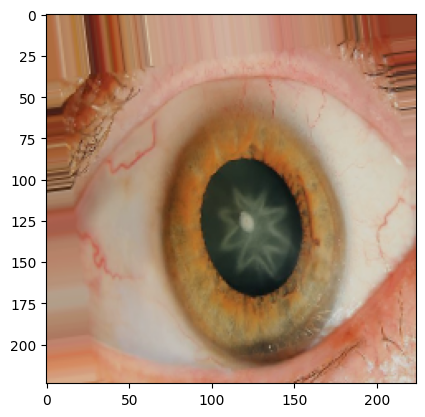

In [35]:
#show a sample image from train_generator
images, labels = next(train_generator)
print(labels[0])
plt.imshow(images[0])

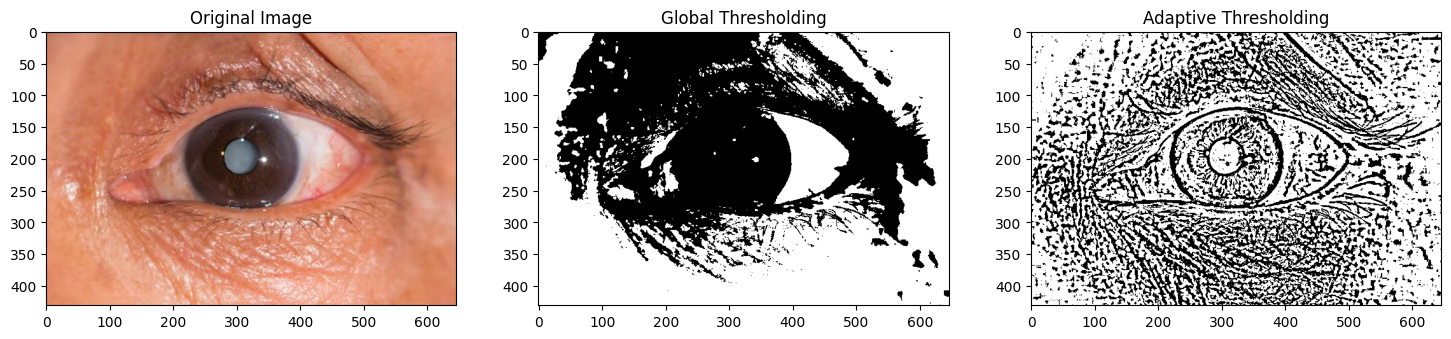

In [8]:
#Image Thresholding
import cv2
import matplotlib.pyplot as plt

image_path = '/Users/muskaan2/ML_Dev/data/processed_images/train/cataract/image_233.png'
image = cv2.imread(image_path)

thresh_ada = cv2.adaptiveThreshold(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

_, thresh = cv2.threshold(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 150, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(thresh, cmap='gray')
plt.title('Global Thresholding')

plt.subplot(1, 3, 3)
plt.imshow(thresh_ada, cmap='gray')
plt.title('Adaptive Thresholding')

plt.show()


Better at preserving local details, like eye contours and wrinkles. It separates objects (foreground) from the background by applying a threshold value.

### Model Training 

In [2]:
train_generator, test_generator = train_test_generators()

Training Categories Labelled as: ['cataract', 'normal']
Found 491 images belonging to 2 classes.

Testing Categories Labelled as: ['cataract', 'normal']
Found 121 images belonging to 2 classes.

Class indices mapping: {'cataract': 0, 'normal': 1}


0.0


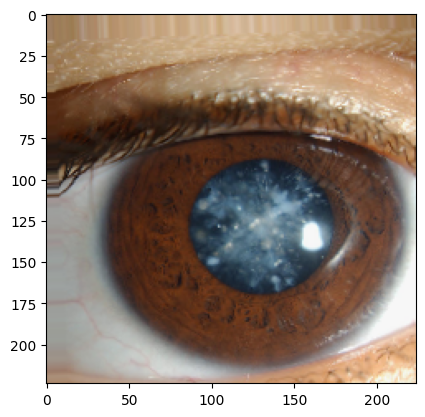

In [6]:
#show a sample image from train_generator
images, labels = next(train_generator)
print(labels[0])
plt.imshow(images[0])

In [7]:
#training on efficientnet without fine tuning
# history, model = train_model_EfficientNetB0(train_generator, test_generator)
history, model = train_model_VGG16(train_generator, test_generator)

Epoch 1/20
16/16 [==============================] - 36s 2s/step - loss: 2.9200 - auc: 0.7849 - recall: 0.6911 - precision: 0.7054 - accuracy: 0.7006 - val_loss: 2.5002 - val_auc: 0.9739 - val_recall: 0.9667 - val_precision: 0.7945 - val_accuracy: 0.8595
Epoch 2/20


/Users/muskaan2/ML_Dev/ml_env/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 37s 2s/step - loss: 2.4185 - auc: 0.9003 - recall: 0.8659 - precision: 0.7948 - accuracy: 0.8208 - val_loss: 2.1209 - val_auc: 0.9796 - val_recall: 0.9000 - val_precision: 0.9310 - val_accuracy: 0.9174
Epoch 3/20
16/16 [==============================] - 36s 2s/step - loss: 2.0229 - auc: 0.9537 - recall: 0.8862 - precision: 0.8549 - accuracy: 0.8676 - val_loss: 1.8149 - val_auc: 0.9854 - val_recall: 0.9167 - val_precision: 0.9167 - val_accuracy: 0.9174
Epoch 4/20
16/16 [==============================] - 36s 2s/step - loss: 1.7537 - auc: 0.9666 - recall: 0.8943 - precision: 0.8835 - accuracy: 0.8880 - val_loss: 1.5925 - val_auc: 0.9896 - val_recall: 0.9333 - val_precision: 0.9825 - val_accuracy: 0.9587
Epoch 5/20
16/16 [==============================] - 37s 2s/step - loss: 1.5687 - auc: 0.9622 - recall: 0.9187 - precision: 0.8898 - accuracy: 0.9022 - val_loss: 1.4124 - val_auc: 0.9918 - val_recall: 0.9667 - val_precision: 0.9206 - val_accuracy: 0.

Epoch 1/10
16/16 [==============================] - 41s 3s/step - loss: 0.7319 - auc: 0.9636 - recall: 0.9390 - precision: 0.8783 - accuracy: 0.9043 - val_loss: 0.6272 - val_auc: 0.9966 - val_recall: 0.9167 - val_precision: 1.0000 - val_accuracy: 0.9587
Epoch 2/10
16/16 [==============================] - 41s 3s/step - loss: 0.6079 - auc: 0.9912 - recall: 0.9756 - precision: 0.9562 - accuracy: 0.9654 - val_loss: 0.5675 - val_auc: 0.9988 - val_recall: 0.9500 - val_precision: 0.9828 - val_accuracy: 0.9669
Epoch 3/10
16/16 [==============================] - 41s 3s/step - loss: 0.5615 - auc: 0.9956 - recall: 0.9878 - precision: 0.9681 - accuracy: 0.9776 - val_loss: 0.5361 - val_auc: 0.9977 - val_recall: 1.0000 - val_precision: 0.9524 - val_accuracy: 0.9752
Epoch 4/10
16/16 [==============================] - 41s 3s/step - loss: 0.5148 - auc: 0.9990 - recall: 0.9919 - precision: 0.9839 - accuracy: 0.9878 - val_loss: 0.5124 - val_auc: 0.9984 - val_recall: 0.9833 - val_precision: 0.9672 - val_a

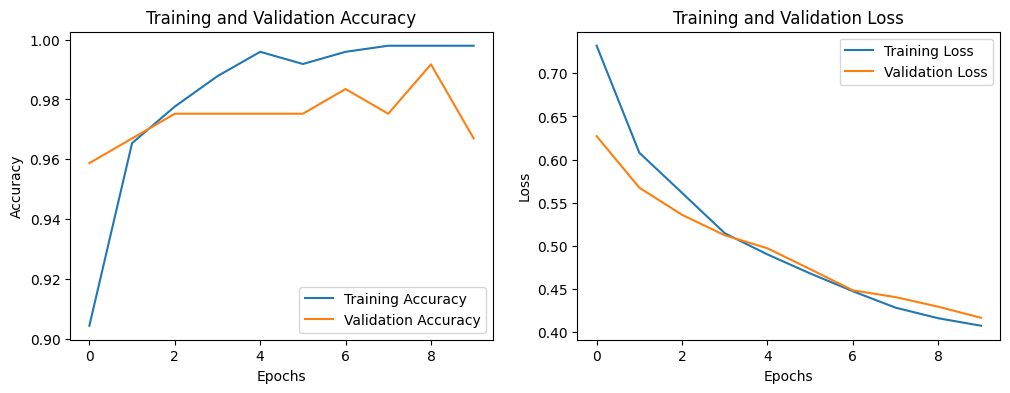

4/4 [==============================] - 8s 2s/step - loss: 0.4169 - auc: 0.9995 - recall: 1.0000 - precision: 0.9375 - accuracy: 0.9669      
Test Accuracy: 99.95%
Test Recall: 100.00%
Test Precision: 93.75%
Test AUC: 96.69%


In [27]:
# Load the best saved model
from tensorflow.keras.models import load_model
best_model = load_model("/Users/muskaan2/ML_Dev/models/best_model_v2_vgg16.h5")

def plot_model_eval_history(history, model, test_generator):
    plt.figure(figsize=(12, 4))
    #plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    #plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    test_loss, test_accuracy, test_recall, test_precision, test_auc = model.evaluate(test_generator)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
    print(f'Test Recall: {test_recall * 100:.2f}%')
    print(f'Test Precision: {test_precision * 100:.2f}%')
    print(f'Test AUC: {test_auc * 100:.2f}%')

# plot the evaluation history of the fine-tuned model
plot_model_eval_history(history, best_model, test_generator)